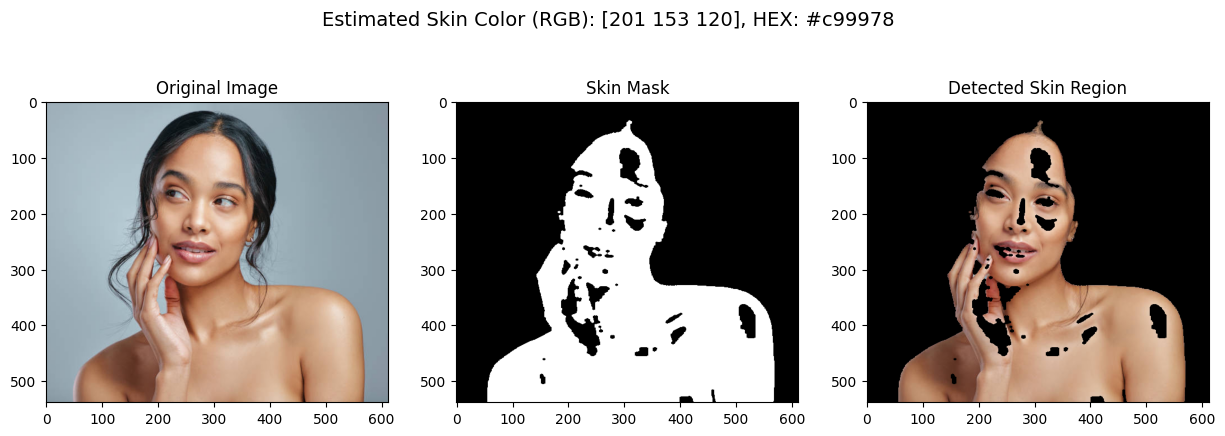

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def skin_detection(image_path):
    # Read and convert image to RGB
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    r, g, b = cv2.split(image_rgb.astype(np.float32))

    # Convert to HSV using OpenCV (scaled to paper's ranges)
    hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)
    h = hsv[:, :, 0] * 2  # Scale to 0-360 degrees
    s = hsv[:, :, 1] / 255.0  # Scale to 0-1

    # Calculate YCbCr using paper's coefficients
    Y = 0.299 * r + 0.287 * g + 0.114 * b
    Cr = r - Y
    Cb = b - Y

    # Condition 1 (HSV + RGB)
    cond1_hsv = (h <= 50) & (s >= 0.23) & (s <= 0.68)
    cond1_rgb = (r > 95) & (g > 40) & (b > 20) & (r > g) & (r > b) & (np.abs(r - g) > 15)
    condition1 = cond1_hsv & cond1_rgb

    # Condition 2 (RGB + YCbCr)
    cond2_rgb = (r > 95) & (g > 40) & (b > 20) & (r > g) & (r > b) & (np.abs(r - g) > 15)
    cond2_ycbcr = (Cr > 135) & (Cb > 85) & (Y > 80)
    cond2_ycbcr &= (Cr <= 1.5862*Cb + 20)
    cond2_ycbcr &= (Cr >= 0.3448*Cb + 76.2069)
    cond2_ycbcr &= (Cr >= -4.5652*Cb + 234.5652)
    cond2_ycbcr &= (Cr <= -1.15*Cb + 301.75)
    cond2_ycbcr &= (Cr <= -2.2857*Cb + 432.85)
    condition2 = cond2_rgb & cond2_ycbcr

    # Final skin mask
    mask = np.where(condition1 | condition2, 255, 0).astype(np.uint8)

    # Morphological cleanup
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    return image_rgb, mask

def get_average_skin_rgb(image_rgb, mask):
    skin_pixels = image_rgb[mask == 255]
    if len(skin_pixels) == 0:
        return (0, 0, 0), "#000000"
    avg_rgb = np.median(skin_pixels, axis=0).astype(int)
    hex_color = '#{:02x}{:02x}{:02x}'.format(*avg_rgb)
    return avg_rgb, hex_color

# Main
image_path = "face.jpg"
original_rgb, skin_mask = skin_detection(image_path)
avg_rgb, hex_color = get_average_skin_rgb(original_rgb, skin_mask)

# Display results
skin_only = cv2.bitwise_and(original_rgb, original_rgb, mask=skin_mask)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1), plt.imshow(original_rgb), plt.title('Original Image')
plt.subplot(1, 3, 2), plt.imshow(skin_mask, cmap='gray'), plt.title('Skin Mask')
plt.subplot(1, 3, 3), plt.imshow(skin_only), plt.title('Detected Skin Region')
plt.suptitle(f"Estimated Skin Color (RGB): {avg_rgb}, HEX: {hex_color}", fontsize=14)
plt.show()


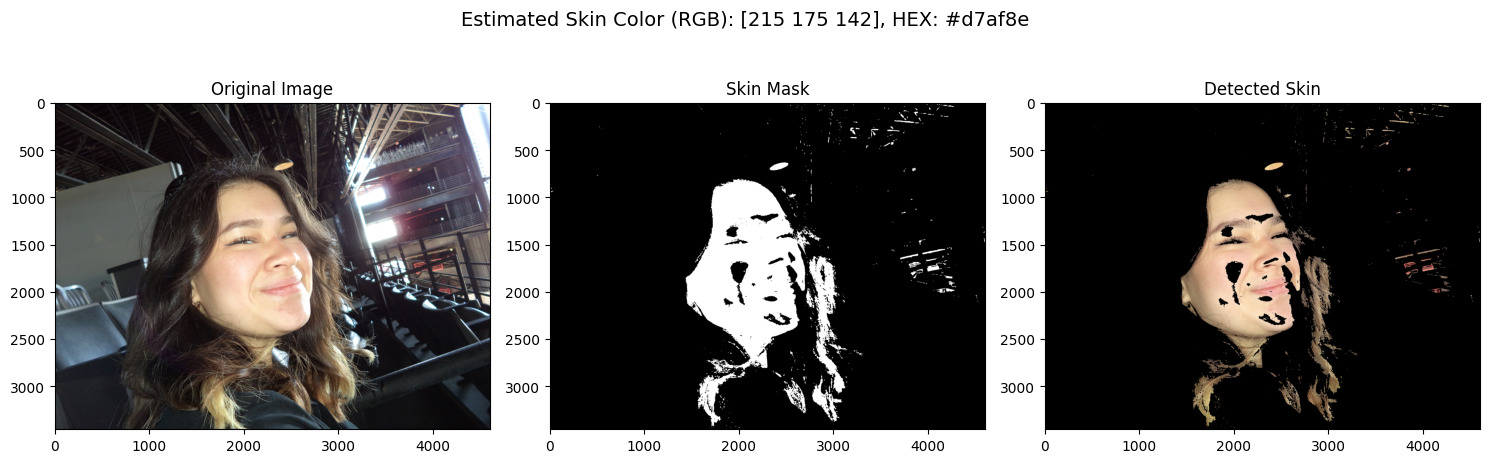

RGB: [215 175 142], HEX: #d7af8e


In [34]:
rgb_val, hex_val, _ = process_image('DSC00119.jpg')
print(f"RGB: {rgb_val}, HEX: {hex_val}")

In [54]:
import cv2
import numpy as np
from skimage import color

def skinDetection_Cornell(img_path):
    # Load image with proper color normalization [1][6]
    img = cv2.imread(img_path)
    img = cv2.resize(img, (400, 400))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Apply research paper's combined thresholds [1]
    ycbcr = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    # RGB thresholds from paper (Section 4)
    r = img[:,:,0]; g = img[:,:,1]; b = img[:,:,2]
    rgb_mask = (
        (r > 95) & (g > 40) & (b > 20) &
        (r > g) & (r > b) & (np.abs(r - g) > 15)
    )
    
    # YCbCr thresholds from paper (Section 4)
    cr = ycbcr[:,:,1]; cb = ycbcr[:,:,2]
    ycbcr_mask = (
        (ycbcr[:,:,0] > 80) &
        (cb >= 85) & (cb <= 135) &
        (cr >= 135) & (cr <= 173)
    )
    
    # HSV thresholds from paper (Section 4)
    h = hsv[:,:,0]; s = hsv[:,:,1]
    hsv_mask = (
        (h >= 0) & (h <= 50) &
        (s >= 0.23*255) & (s <= 0.68*255)
    )
    
    # Combined mask using logical AND [1]
    final_mask = rgb_mask & ycbcr_mask & hsv_mask
    
    # Perceptual color processing in LAB space [6]
    lab_img = color.rgb2lab(img[final_mask])

    # Weighted median calculation (avoids dark bias)
    weights = np.array([0.2, 0.5, 0.3])  # Emphasize L-channel
    weighted_median = np.median(lab_img * weights, axis=0) / weights
    
    # LAB to RGB conversion with brightness compensation
    lab_array = np.array([[weighted_median]], dtype=np.float32)
    rgb_dominant = color.lab2rgb(lab_array)[0][0] * 255
    
    # Gamma correction (2.2) to counteract dark outputs
    rgb_corrected = 255 * (rgb_dominant/255) ** (1/2.2)
    
    # HEX conversion with clamping
    hex_color = '#{:02x}{:02x}{:02x}'.format(
        *np.clip(rgb_corrected, 0, 255).astype(int)
    )
    
    return rgb_corrected.astype(int), hex_color, final_mask




In [59]:
rgb_val, hex_val, _ = skinDetection_Cornell('images/face.jpg')
print(f"RGB: {rgb_val}, HEX: {hex_val}")

RGB: [228 203 184], HEX: #e4cbb8


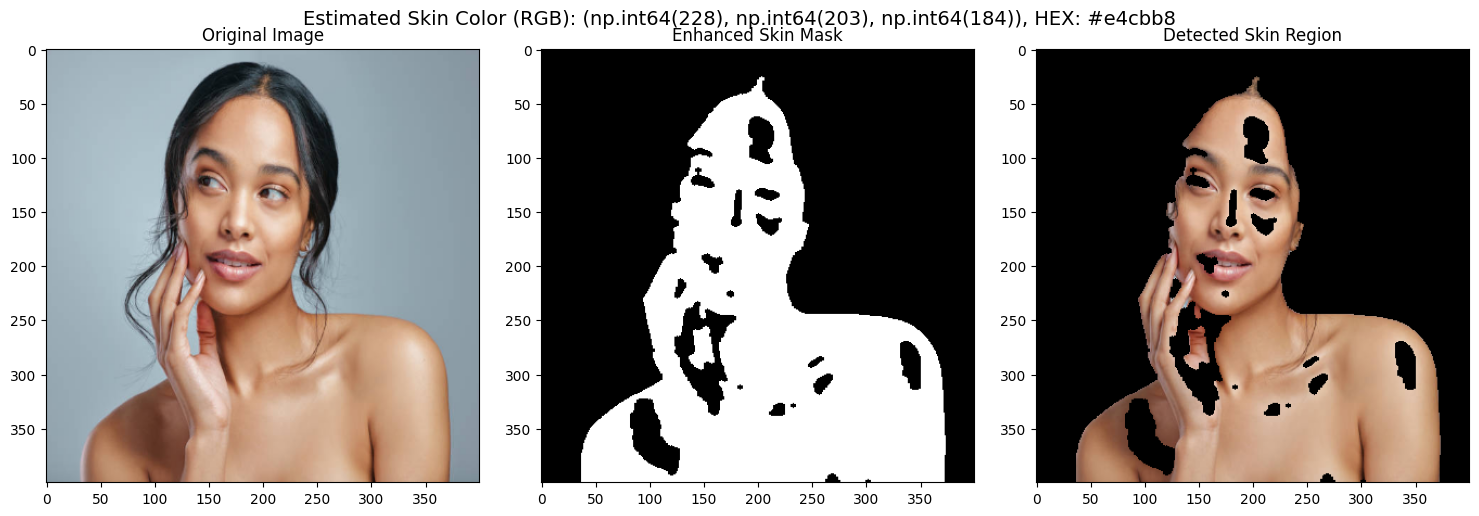

Enhanced RGB: (np.int64(228), np.int64(203), np.int64(184)), HEX: #e4cbb8


In [58]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import color

def enhanced_skin_detection(image_rgb):
    """ Skin detection using RGB, YCbCr, HSV + LAB perceptual median."""
    img = cv2.resize(image_rgb, (400, 400))
    
    ycbcr = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]
    rgb_mask = (
        (r > 95) & (g > 40) & (b > 20) &
        (r > g) & (r > b) & (np.abs(r - g) > 15)
    )

    cr, cb = ycbcr[:,:,1], ycbcr[:,:,2]
    ycbcr_mask = (
        (ycbcr[:,:,0] > 80) &
        (cb >= 85) & (cb <= 135) &
        (cr >= 135) & (cr <= 173)
    )

    h, s = hsv[:,:,0], hsv[:,:,1]
    hsv_mask = (
        (h >= 0) & (h <= 50) &
        (s >= 0.23*255) & (s <= 0.68*255)
    )

    final_mask = (rgb_mask & ycbcr_mask & hsv_mask).astype(np.uint8) * 255

    # Morphological cleanup
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_CLOSE, kernel)
    final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_OPEN, kernel)

    return img, final_mask

def get_perceptual_median_color(image_rgb, mask):
    """Get perceptual median skin color in LAB with gamma correction."""
    skin_pixels = image_rgb[mask == 255]
    if skin_pixels.size == 0:
        return (0, 0, 0), "#000000"

    lab_img = color.rgb2lab(skin_pixels / 255.0)
    weights = np.array([0.2, 0.5, 0.3])
    weighted_median = np.median(lab_img * weights, axis=0) / weights

    lab_array = np.array([[weighted_median]], dtype=np.float32)
    rgb_dominant = color.lab2rgb(lab_array)[0][0] * 255
    rgb_corrected = 255 * (rgb_dominant / 255) ** (1 / 2.2)

    rgb_int = np.clip(rgb_corrected, 0, 255).astype(int)
    hex_color = '#{:02x}{:02x}{:02x}'.format(*rgb_int)
    return tuple(rgb_int), hex_color

def display_results(image_rgb, mask, avg_rgb, hex_color):
    """Visualize original, mask, and skin detection results."""
    skin_only = cv2.bitwise_and(image_rgb, image_rgb, mask=mask)
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1), plt.imshow(image_rgb), plt.title('Original Image')
    plt.subplot(1, 3, 2), plt.imshow(mask, cmap='gray'), plt.title('Enhanced Skin Mask')
    plt.subplot(1, 3, 3), plt.imshow(skin_only), plt.title('Detected Skin Region')
    plt.suptitle(f"Estimated Skin Color (RGB): {avg_rgb}, HEX: {hex_color}", fontsize=14)
    plt.tight_layout()
    plt.show()

def process_image_enhanced(image_path):
    """Full pipeline with enhanced detection and display."""
    img_bgr = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    resized_rgb, skin_mask = enhanced_skin_detection(img_rgb)
    avg_rgb, hex_color = get_perceptual_median_color(resized_rgb, skin_mask)

    display_results(resized_rgb, skin_mask, avg_rgb, hex_color)

    return avg_rgb, hex_color, skin_mask

# Skin Analysis using OpenCV conversion & Direct threshold from Cornell University
rgb_val, hex_val, _ = process_image_enhanced('images/face.jpg')
print(f"Enhanced RGB: {rgb_val}, HEX: {hex_val}")

